# Tackling imbalanced dataset


# Baseline

In [45]:
# source: https://www.kaggle.com/ntnu-testimon/paysim1
import os
import pandas as pd
import numpy as np

df = pd.read_csv("PS_20174392719_1491204439457_log.csv", na_values=['NA', '?'])
df = df.reindex(np.random.permutation(df.index))
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
638902,35,CASH_OUT,76123.25,C1573544958,0.00,0.00,C1312783109,2425171.22,3048622.30,0,0
5949068,405,PAYMENT,3355.86,C416720986,106037.00,102681.14,M509316004,0.00,0.00,0,0
5412563,378,CASH_OUT,74305.28,C1907870282,0.00,0.00,C249895182,255127.27,329432.56,0,0
622934,34,PAYMENT,19075.86,C707346859,0.00,0.00,M162431398,0.00,0.00,0,0
1184123,132,PAYMENT,37570.36,C1809108575,54529.04,16958.68,M809986319,0.00,0.00,0,0


In [47]:
enc = LabelEncoder()

def columnEncoder(columns):
    for column_name,space in columns:
        enc.fit(df[column_name])
        enc_type = enc.transform(df[column_name])
        df.insert(space,"encoded_" + column_name,enc_type)
        df.pop(column_name)

change = [['nameOrig',4],['nameDest',7],['type',1]]
col_enc = columnEncoder(change)
df[:5]

,step,encoded_type,amount,encoded_nameOrig,oldbalanceOrg,newbalanceOrig,encoded_nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
638902,35,1,76123.25,1883272,0.00,0.00,92648,2425171.22,3048622.30,0,0
5949068,405,3,3355.86,4434160,106037.00,102681.14,2175954,0.00,0.00,0,0
5412563,378,1,74305.28,2982836,0.00,0.00,350104,255127.27,329432.56,0,0
622934,34,3,19075.86,5390563,0.00,0.00,1267265,0.00,0.00,0,0
1184123,132,3,37570.36,2657971,54529.04,16958.68,2510413,0.00,0.00,0,0


In [48]:

#Splitting into samples and labels
x = np.array(df.iloc[:,:8])
y = np.array(df.iloc[:,9])
one_hot = np_utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(x,one_hot,test_size=0.20,random_state=21)



In [49]:
model = Sequential()
model.add(Dense(60, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(one_hot.shape[1],activation='softmax'))

In [50]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.fit(X_train,y_train,batch_size=128,verbose=2,epochs=5)


Epoch 1/5
 - 62s - loss: 0.0091
Epoch 2/5
 - 47s - loss: 0.0085
Epoch 3/5
 - 48s - loss: 0.0086
Epoch 4/5
 - 75s - loss: 0.0086
Epoch 5/5
 - 56s - loss: 0.0084


In [51]:
pred = model.predict(X_test) 
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1) 
accuracy = metrics.accuracy_score(y_compare, pred)
precision = metrics.average_precision_score(y_compare, pred)
print("Accuracy score: {}".format(accuracy))
print("precision score: {}".format(precision))

y_test_1d = np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test_1d, pred)
np.set_printoptions(suppress=True)
normalized_m = preprocessing.normalize(matrix)
print("Confusion matrix: \n",normalized_m)


Accuracy score: 0.9988094527097328
precision score: 0.07340647633506653
Confusion matrix: 
 [[1.         0.00000866]
 [0.99639801 0.08479983]]


In [52]:
from sklearn.metrics import f1_score
f1=f1_score(y_test_1d, pred)
f1

0.1445511010728402

# First technique: undersampling

In [30]:
# source: https://www.kaggle.com/ntnu-testimon/paysim1
import os
import pandas as pd
import numpy as np

df = pd.read_csv("PS_20174392719_1491204439457_log.csv", na_values=['NA', '?'])
df = df.reindex(np.random.permutation(df.index))
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4843790,347,CASH_OUT,105780.74,C969234974,0.0,0.00,C2127584278,985892.53,1091673.27,0,0
4702106,331,PAYMENT,2358.98,C1427232242,0.0,0.00,M1096057974,0.00,0.00,0,0
1925387,167,CASH_OUT,97097.01,C611265056,0.0,0.00,C1087470396,2640297.20,2737394.21,0,0
4791098,345,CASH_OUT,151014.09,C1217023585,0.0,0.00,C2004353988,661113.51,812127.60,0,0
2526420,205,PAYMENT,6936.59,C1457126493,245776.0,238839.41,M772826169,0.00,0.00,0,0


In [31]:
""" 
The creator of this simulation writes that:
isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Therefore, only using 'isFraud' label to separate actual fraudulent transactions.
"""

dfLegitimate = df[df.isFraud == 0]
dfFraud = df[df.isFraud == 1]
dfLegitimate[:5]


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4843790,347,CASH_OUT,105780.74,C969234974,0.0,0.00,C2127584278,985892.53,1091673.27,0,0
4702106,331,PAYMENT,2358.98,C1427232242,0.0,0.00,M1096057974,0.00,0.00,0,0
1925387,167,CASH_OUT,97097.01,C611265056,0.0,0.00,C1087470396,2640297.20,2737394.21,0,0
4791098,345,CASH_OUT,151014.09,C1217023585,0.0,0.00,C2004353988,661113.51,812127.60,0,0
2526420,205,PAYMENT,6936.59,C1457126493,245776.0,238839.41,M772826169,0.00,0.00,0,0


In [32]:
print(dfFraud.shape)
print(dfLegitimate.shape)

(8213, 11)
(6354407, 11)


In [33]:
#Setting exactly the same size for both categories
dfLegit = dfLegitimate.head(8213)

In [34]:
undersampled = pd.concat([dfLegit,dfFraud])
undersampled

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4843790,347,CASH_OUT,105780.74,C969234974,0.00,0.00,C2127584278,985892.53,1091673.27,0,0
4702106,331,PAYMENT,2358.98,C1427232242,0.00,0.00,M1096057974,0.00,0.00,0,0
1925387,167,CASH_OUT,97097.01,C611265056,0.00,0.00,C1087470396,2640297.20,2737394.21,0,0
4791098,345,CASH_OUT,151014.09,C1217023585,0.00,0.00,C2004353988,661113.51,812127.60,0,0
2526420,205,PAYMENT,6936.59,C1457126493,245776.00,238839.41,M772826169,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6089320,522,TRANSFER,146908.38,C2104935185,146908.38,0.00,C1426723471,0.00,0.00,1,0
6201740,578,CASH_OUT,118106.94,C984782155,118106.94,0.00,C1461492607,1908450.58,2026557.52,1,0
4785646,341,TRANSFER,357824.01,C45970482,357824.01,0.00,C687230384,0.00,0.00,1,0
5841056,402,CASH_OUT,4257337.62,C1677738676,4257337.62,0.00,C1017016927,3108.24,4260445.86,1,0


In [35]:
from sklearn.preprocessing import LabelEncoder

#undersampled.pop("isFlaggedFraud")

enc = LabelEncoder()
def columnEncoder(columns):
    for column_name,space in columns:
        enc.fit(undersampled[column_name])
        enc_type = enc.transform(undersampled[column_name])
        undersampled.insert(space,"encoded_" + column_name,enc_type)
        undersampled.pop(column_name)

change = [['nameOrig',4],['nameDest',7],['type',1]]

undersampled_enc = columnEncoder(change)

In [36]:
# Second reshuffling for to mix both categories
undersampled = undersampled.reindex(np.random.permutation(undersampled.index))
undersampled[:5]

,step,encoded_type,amount,encoded_nameOrig,oldbalanceOrg,newbalanceOrig,encoded_nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4372947,310,1,1334919.42,10611,1334919.42,0.0,10114,2565752.24,3900671.66,1,0
6118161,531,1,6392800.85,5563,6392800.85,0.0,7732,337849.17,6730650.03,1,0
3182792,239,1,425221.11,13478,425221.11,0.0,5994,1107020.73,1532241.85,1,0
1030575,74,4,59127.34,3793,59127.34,0.0,13117,0.00,0.00,1,0
5993689,420,4,430722.59,1049,430722.59,0.0,3352,0.00,0.00,1,0


In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#Splitting into samples and labels
x = np.array(undersampled.iloc[:,:8])
y = np.array(undersampled.iloc[:,9])
x[:5]

array([[    310.  ,       1.  , 1334919.42,   10611.  , 1334919.42,
              0.  ,   10114.  , 2565752.24],
       [    531.  ,       1.  , 6392800.85,    5563.  , 6392800.85,
              0.  ,    7732.  ,  337849.17],
       [    239.  ,       1.  ,  425221.11,   13478.  ,  425221.11,
              0.  ,    5994.  , 1107020.73],
       [     74.  ,       4.  ,   59127.34,    3793.  ,   59127.34,
              0.  ,   13117.  ,       0.  ],
       [    420.  ,       4.  ,  430722.59,    1049.  ,  430722.59,
              0.  ,    3352.  ,       0.  ]])

In [38]:
from keras.utils import np_utils

# convert integers to dummy variables (i.e. one hot encoded)
one_hot = np_utils.to_categorical(y)
one_hot[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x,one_hot,test_size=0.20,random_state=21)


### Training part

In [40]:
from keras.models import Sequential
from keras.layers.core import Dense

model = Sequential()
model.add(Dense(60, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(one_hot.shape[1],activation='softmax'))

In [41]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.fit(X_train,y_train,batch_size=128,verbose=2,epochs=5)
#action = model.predict(image)

Epoch 1/5
 - 0s - loss: 0.5379
Epoch 2/5
 - 0s - loss: 0.3340
Epoch 3/5
 - 0s - loss: 0.2585
Epoch 4/5
 - 0s - loss: 0.2229
Epoch 5/5
 - 0s - loss: 0.2074


In [42]:
from sklearn import metrics
#using test set for prediction
pred = model.predict(X_test) 
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1) 
accuracy = metrics.accuracy_score(y_compare, pred)
precision = metrics.average_precision_score(y_compare, pred)
print("Accuracy score: {}".format(accuracy))
print("precision score: {}".format(precision))



Accuracy score: 0.9223980523432745
precision score: 0.9105937056916148


In [44]:
from sklearn.metrics import f1_score
f1=f1_score(y_test_1d, pred)
f1

0.9200877467878409

Confusion matrix, without normalization
[[1563   51]
 [ 204 1468]]


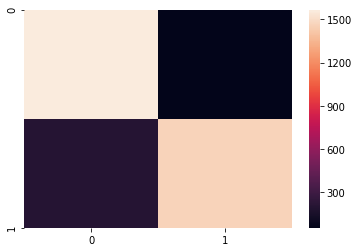

[[0.99946808 0.0326122 ]
 [0.13764192 0.99048206]]


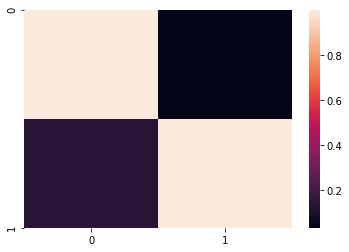

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.metrics import plot_confusion_matrix # change to v.0.22 to have this one
import seaborn as sn
#formatting labels from one_hot encoding
y_test_1d = np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test_1d, pred)
print('Confusion matrix, without normalization')
print(matrix)
sn.heatmap(matrix)
plt.show()

normalized_m = preprocessing.normalize(matrix)
print(normalized_m)
sn.heatmap(normalized_m) 
plt.show()

# Another techniques
# weight adjustment

In [1]:
# source: https://www.kaggle.com/ntnu-testimon/paysim1
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline



df2 = pd.read_csv("PS_20174392719_1491204439457_log.csv", na_values=['NA', '?'])
df2 = df2.reindex(np.random.permutation(df2.index))
df2.head()

Using TensorFlow backend.


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2892050,228,PAYMENT,12348.84,C1984975377,555962.0,543613.16,M865101115,0.00,0.00,0,0
1849081,163,PAYMENT,14534.41,C1425462448,25533.0,10998.59,M1616539308,0.00,0.00,0,0
6328585,688,CASH_IN,39846.67,C601240722,20640.0,60486.67,C616209107,2908578.83,2868732.15,0,0
3696063,277,PAYMENT,5438.70,C1670301032,0.0,0.00,M521814532,0.00,0.00,0,0
5151126,357,CASH_OUT,7396.85,C1408043643,50754.0,43357.15,C1807882356,98922.71,106319.56,0,0


In [2]:
enc = LabelEncoder()

def columnEncoder(columns):
    for column_name,space in columns:
        enc.fit(df2[column_name])
        enc_type = enc.transform(df2[column_name])
        df2.insert(space,"encoded_" + column_name,enc_type)
        df2.pop(column_name)

change = [['nameOrig',4],['nameDest',7],['type',1]]

col_enc = columnEncoder(change)


df2[:5]

,step,encoded_type,amount,encoded_nameOrig,oldbalanceOrg,newbalanceOrig,encoded_nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2892050,228,3,12348.84,3236851,555962.0,543613.16,2571642,0.00,0.00,0,0
1849081,163,3,14534.41,1397221,25533.0,10998.59,1258567,0.00,0.00,0,0
6328585,688,0,39846.67,5041810,20640.0,60486.67,458166,2908578.83,2868732.15,0,0
3696063,277,3,5438.70,2201309,0.0,0.00,2189967,0.00,0.00,0,0
5151126,357,1,7396.85,1339643,50754.0,43357.15,239015,98922.71,106319.56,0,0


In [9]:
df2.head()

,step,encoded_type,amount,encoded_nameOrig,oldbalanceOrg,newbalanceOrig,encoded_nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3466159,257,3,19465.33,2454799,163256.17,143790.84,1640552,0.00,0.00,0,0
2112758,183,3,8370.94,5580091,398885.99,390515.05,2452910,0.00,0.00,0,0
3502303,259,4,596881.02,375457,104549.00,0.00,152654,1053756.15,1650637.18,0,0
68581,9,3,3882.62,6143570,539325.42,535442.80,1130168,0.00,0.00,0,0
516916,20,3,2261.25,3720867,0.00,0.00,2259223,0.00,0.00,0,0


In [3]:
#Splitting into samples and labels
x = np.array(df2.iloc[:,:8])
y = np.array(df2.iloc[:,9])
one_hot = np_utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(x,one_hot,test_size=0.20,random_state=21)

In [4]:
model = Sequential()
model.add(Dense(60, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(one_hot.shape[1],activation='softmax'))

In [7]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.fit(X_train,y_train,batch_size=128,class_weight="balanced",verbose=2,epochs=10)
#action = model.predict(image)

Epoch 1/10
 - 53s - loss: 0.0077
Epoch 2/10
 - 48s - loss: 0.0077
Epoch 3/10
 - 55s - loss: 0.0079
Epoch 4/10
 - 57s - loss: 0.0076
Epoch 5/10
 - 59s - loss: 0.0076
Epoch 6/10
 - 46s - loss: 0.0076
Epoch 7/10
 - 46s - loss: 0.0080
Epoch 8/10
 - 48s - loss: 0.0078
Epoch 9/10
 - 46s - loss: 0.0080
Epoch 10/10
 - 46s - loss: 0.0080


In [11]:
from sklearn import metrics

pred = model.predict(X_test) 
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1) 
accuracy = metrics.accuracy_score(y_compare, pred)
precision = metrics.average_precision_score(y_compare, pred)
print("Accuracy score: {}".format(accuracy))
print("Precision score: {}".format(precision))

y_test_1d = np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test_1d, pred)
np.set_printoptions(suppress=True)
normalized_m = preprocessing.normalize(matrix)
print("Confusion matrix: \n",normalized_m)


Accuracy score: 0.9988558172576706
Precision score: 0.12588265072781843
Confusion matrix: 
 [[1.         0.00001416]
 [0.98808398 0.15391572]]


In [12]:
from sklearn.metrics import f1_score
f1=f1_score(y_test_1d, pred)
f1

0.23529411764705882

# Upsampling of minority class

In [13]:
from sklearn.utils import resample

dfLegitimate = df2[df2.isFraud == 0]
dfFraud = df2[df2.isFraud == 1]

upsample_f = resample(dfFraud,
                          replace=True,
                          n_samples=len(dfLegitimate),
                          random_state=21)


In [14]:
len(upsample_f)

6354407

In [15]:
df2.size

69988820

In [16]:

#Splitting into samples and labels
x = np.array(df2.iloc[:,:8])
y = np.array(df2.iloc[:,9])
one_hot = np_utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(x,one_hot,test_size=0.20,random_state=21)



In [17]:
model = Sequential()
model.add(Dense(60, input_dim=x.shape[1], activation='sigmoid'))
model.add(Dense(20, activation='sigmoid'))
model.add(Dense(one_hot.shape[1],activation='softmax'))

In [18]:
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
model.fit(X_train,y_train,batch_size=128,verbose=2,epochs=5)


Epoch 1/5
 - 57s - loss: 0.0081
Epoch 2/5
 - 62s - loss: 0.0081
Epoch 3/5
 - 51s - loss: 0.0081
Epoch 4/5
 - 51s - loss: 0.0078
Epoch 5/5
 - 49s - loss: 0.0076


In [19]:
pred = model.predict(X_test) 
pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1) 
accuracy = metrics.accuracy_score(y_compare, pred)
precision = metrics.average_precision_score(y_compare, pred)
print("Accuracy score: {}".format(accuracy))
print("precision score: {}".format(precision))

y_test_1d = np.argmax(y_test, axis=1)
matrix = confusion_matrix(y_test_1d, pred)
np.set_printoptions(suppress=True)
normalized_m = preprocessing.normalize(matrix)
print("Confusion matrix: \n",normalized_m)


Accuracy score: 0.9989163269219283
precision score: 0.17714978278780935
Confusion matrix: 
 [[1.         0.00004958]
 [0.96713163 0.25427625]]


In [20]:
from sklearn.metrics import f1_score
f1=f1_score(y_test_1d, pred)
f1

0.3341380975374215